In [129]:
import pandas as pd
import numpy as np
import re
from fuzzywuzzy import fuzz, process
from text2digits import text2digits

In [130]:
file_id = "1I0FV3xVcA8tkonsb8rvrSaOAYofew6-d"
download_url = f"https://drive.google.com/uc?export=download&id={file_id}"
df = pd.read_csv(download_url)

In [131]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13013 entries, 0 to 13012
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   facility_id         9305 non-null   object
 1   facility_name       12989 non-null  object
 2   facility_type       11015 non-null  object
 3   capacity            10361 non-null  object
 4   region              12980 non-null  object
 5   licence_issue_date  12990 non-null  object
 6   inspection_date     13002 non-null  object
 7   gps_location        10721 non-null  object
 8   remarks             10080 non-null  object
dtypes: object(9)
memory usage: 915.1+ KB


In [132]:
df.isnull().sum()

facility_id           3708
facility_name           24
facility_type         1998
capacity              2652
region                  33
licence_issue_date      23
inspection_date         11
gps_location          2292
remarks               2933
dtype: int64

In [133]:
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 1672


In [134]:
df[df.duplicated()]

,facility_id,facility_name,facility_type,capacity,region,licence_issue_date,inspection_date,gps_location,remarks
5,HF-0003,"Powell, Morales and Butler Infirmary",Health Ctr.,179 capacity,ST. LUCY,November 21 2020,07-03-24,"12.77293, -59.04279",Follow-up 2023
8,NaN,May and Sons Medical Center (St),Polyclinic 🏥,ten beds,St Peter,20160217,2018-01-01,13°2′6″N 59°0′38″W,Follow-up 2023
24,2ba130,Brown PLC Polyclinic,Polyclinic 🏥,NaN,St James,July 07 2016,28 May 2024,12°43′45″N 59°17′10″W,Reinspection due
27,022,Baker-Taylor Hosp.,NaN,NaN,St. Joseph,02/04/18,20190602,"-59.24115, 12.70994",NaN
37,029,"Bentley, Scott and Graves Clinic",NaN,NaN,St. Joseph,22 Dec 2019,20191030,"13.24629, -58.98848",-
...,...,...,...,...,...,...,...,...,...
12926,HF-9969,"Gomez, Holmes and Hill Polyclinic",Community Health Centre,NaN,St Andrew,27-08-22,03 Oct 2019,-59.08220;13.25967,NaN
12934,9975,Miller-Ramirez Polyclinic (St),Polyclinic 🏥,NaN,St George,26 Jan 2024,23 Feb 2023,NaN,
12947,#9986,Kelley Ltd Clinic (St.Joseph),NaN,NaN,St.Joseph,05-04-24,02-03-18,"-59.04337, 13.11984",Good
12955,NaN,Singh-Booth Hosp. (st.),Hosp.,409 beds,st. james,20211104,05-04-18,"13.04595, -58.90038",Follow-up 2023


Removing duplicates

In [135]:
df.drop_duplicates(inplace=True)

Cleaning facility_id column

In [136]:
#Removing all characters except letters and numbers
df["facility_id"] = df["facility_id"].str.replace(r'[^a-zA-Z0-9]', '', regex=True)

#Fill missing spaces with the word "missing"
df["facility_id"] = df["facility_id"].fillna("missing")

Cleaning facility_name column

In [137]:
# Remove text in parentheses
df["facility_name"] = df["facility_name"].str.replace(r"\(.*?\)", "", regex=True)
df["facility_name"] = df["facility_name"].str.replace(r'[^a-zA-Z\- ]', '', regex=True)
# Remove emojis (unicode ranges for most emojis)
df["facility_name"] = df["facility_name"].str.replace(r"[^\w\s,.-]", "", regex=True)
# Remove extra whitespace
df["facility_name"] = df["facility_name"].str.strip()

In [138]:
df["facility_name"].head(5)

0          Burgess-Ingram Medical Center
1                            Collins Inc
2                     Butler-Leon Clinic
3                     Butler-Leon Clinic
4    Powell Morales and Butler Infirmary
Name: facility_name, dtype: object

Cleaning the facility_type column

In [139]:
#make all entries lowercase and remove emojis
df["facility_type"] = df["facility_type"].str.lower().replace(r"[^a-zA-Z\- ]", "", regex=True)
df["facility_type"]=df["facility_type"].str.strip()

In [140]:
df["facility_type"].unique()

array(['community health ctr', 'hosp', 'hospital', 'health ctr',
       'polyclinic', 'health centre', 'clinic', 'community health centre',
       nan, 'chc'], dtype=object)

In [141]:

df["facility_type"] = df["facility_type"].replace({
    'community health ctr': 'community health center',
    'hosp': 'hospital', 
    'hospital': 'hospital', 
    'health ctr': 'health center',
    'polyclinic': 'polyclinic',
    'health centre': 'health center',
    'clinic': 'clinic',
    'community health centre': 'community health center',
    'chc': 'community health center'
})
df["facility_type"] = df["facility_type"].fillna("missing")

Cleaning the region column

In [142]:
# First, fix backwards names
df["region"] = df["region"].replace({
    "werdna .ts": "st. andrew",
    "egroeg .ts": "st. george",
    "semaj .ts": "st. james",
    "nhoj .ts": "st. john",
    "hpesoj .ts": "st. joseph",
    "ycul .ts": "st. lucy",
    "leahcim .ts": "st. michael",
    "retep .ts": "st. peter",
    "pilihp .ts": "st. philip",
    "samohT .ts": "st. thomas",
    "hcruhc tsirhc": "christ church"
})

# Then fuzzy match to standardize
parishes = [
    "st. andrew",   
    "st. george", 
    "st. james",
    "st. john",
    "st. joseph",
    "st. lucy",
    "st. michael",
    "st. peter",
    "st. philip",
    "st. thomas",
    "christ church"
]

def match_parish(region):
    if pd.isnull(region):
        return np.nan
    region = str(region).lower().strip()
    match, score = process.extractOne(region, parishes)
    if score >= 80:
        return match
    return np.nan

df["region"] = df["region"].apply(match_parish)


In [143]:
df["region"] = df["region"].fillna("missing")

In [144]:
df[["region"]].head(50)

,region
0,st. lucy
1,st. peter
2,st. james
3,st. james
4,st. lucy
6,st. andrew
7,st. peter
9,st. andrew
10,st. james
11,st. lucy


Clean the gps_location column

In [145]:
df["gps_location"]= df["gps_location"].str.strip().str.lower()

invalid_gps = ["unknown", "missing", "n/a", "empty", "0,0", "na", ""]

df["gps_location"] = df["gps_location"].replace(invalid_gps, "0")

df["gps_location"] = df["gps_location"].str.replace(r'[^0-9]', '', regex=True)



In [146]:
def extract_lon_lat(gps):
    if pd.isnull(gps):
        return pd.Series([13.00, -59.00])
    
    gps = str(gps)
    count = len(gps)

    # Make it even by trimming or noting the last digit
    if count % 2 == 0:
        mid = count // 2
        part1 = gps[:mid]
        part2 = gps[mid:]
    else:
        gps = gps[:-1]  # remove last digit to make it even
        mid = len(gps) // 2
        part1 = gps[:mid]
        part2 = gps[mid:]

    # Assume 2 digits before decimal
    def convert(part):
        return float(part[:2] + "." + part[2:]) if len(part) > 2 else np.nan

    A = convert(part1)
    B = convert(part2)

    #latitude has smaller absolute value
    if abs(A) < abs(B):
        LAT, LON = A,-abs(B)
    else:
        LAT, LON = B, -abs(A)

    return pd.Series([LAT, LON])
df[["latitude", "longitude"]] = df["gps_location"].apply(extract_lon_lat)


In [147]:
df[["latitude", "longitude"]].head(5)

,latitude,longitude
0,13.08576,-58.75331
1,12.87196,-58.84001
2,13.00952,-58.82307
3,13.00952,-58.82307
4,12.77293,-59.04279


Cleaning capacity column

In [148]:
t2d = text2digits.Text2Digits()

# Convert text numbers to digits
df["capacity"] = df["capacity"].apply(lambda x: t2d.convert(str(x)))


In [149]:
#keep numbers only
df["capacity"]= df["capacity"].str.replace(r'[^0-9]', '', regex =True)

In [150]:
df["capacity"].replace("", np.nan, inplace=True)
df["capacity"] = df["capacity"].fillna(0).astype(int)
means = np.floor(df.groupby("facility_type")["capacity"].mean()).astype(int)
print(means)

facility_type
clinic                     146
community health center    152
health center              136
hospital                   147
missing                    139
polyclinic                 144
Name: capacity, dtype: int32


In [151]:
df["capacity"]

0        250
1          0
2        117
3        117
4        179
        ... 
13008      0
13009      0
13010      0
13011      0
13012      0
Name: capacity, Length: 11341, dtype: int32

In [152]:
print(df["capacity"].isnull().sum())

0


Cleaning licence_issue_date column

In [153]:
# Convert the date column to datetime, coerce errors to NaT (Not a Time)
df["licence_issue_date"] = pd.to_datetime(df["licence_issue_date"], errors="coerce")
df[["licence_issue_date"]].head(20)


,licence_issue_date
0,2021-04-01
1,2024-03-28
2,2016-02-18
3,2016-02-18
4,2020-11-21
6,2021-04-17
7,2016-02-17
9,2021-06-11
10,2018-05-18
11,2025-09-09


Cleaning inspection_date column

In [154]:
df["inspection_date"] = pd.to_datetime(df["inspection_date"], errors="coerce")
df["inspection_date"].head(20)

0    2024-03-08
1    2023-04-17
2    2022-12-30
3    2022-12-30
4    2024-07-03
6    2024-01-31
7    2018-01-01
9    2018-03-22
10   2019-07-31
11   2025-09-26
12   2024-08-15
13   2019-12-16
14   2019-03-13
15   2023-05-06
16   2022-08-01
17   2025-11-18
18   2023-08-01
19   2018-05-16
20   2023-07-24
21   2024-09-25
Name: inspection_date, dtype: datetime64[ns]

Cleaning remarks column

In [155]:
df["remarks"] = df["remarks"].str.strip().str.lower().str.replace(r'[^a-z\ ]', "" , regex=True)
df["remarks"] = df["remarks"].fillna("missing")

In [156]:
mask = (
    df["facility_id"].isin(["missing", "", "--"]) &
    df["facility_name"].isin(["missing", "", "--"]) &
    df["gps_location"].isin(["missing", "", "--"])
)
df = df[~mask]

In [157]:
df.tail(100)


,facility_id,facility_name,facility_type,capacity,region,licence_issue_date,inspection_date,gps_location,remarks,latitude,longitude
12896,9946,Hill PLC Clinic,health center,99,st. peter,2018-05-24,2023-08-29,58883301278262,,12.78262,-58.88330
12897,9946,Hill PLC Clin,health center,99,st. peter,2018-05-24,2023-08-29,58883301278262,,12.78262,-58.88330
12898,HF9947,Harvey-Bradley Hospital,health center,40,st. andrew,2019-01-10,2020-07-31,1371359718,,13.71300,-59.71800
12899,HF9948,Wilson-Armstrong-and-Nicholson Clinic,health center,198,missing,2017-11-19,2023-06-18,58742941317336,reinspection due,13.17336,-58.74294
12900,9949,Webster Inc Polyclinic,health center,33,st. lucy,2018-01-09,2019-10-14,58818731317437,needs upgrade,13.17437,-58.81873
...,...,...,...,...,...,...,...,...,...,...,...
13006,missing,,missing,0,missing,NaT,NaT,NaN,,13.00000,-59.00000
13007,,NaN,missing,0,missing,NaT,NaT,NaN,missing,13.00000,-59.00000
13008,,NaN,missing,0,missing,NaT,NaT,,,NaN,NaN
13009,missing,NaN,missing,0,missing,NaT,NaT,0,,NaN,NaN


In [158]:
df.to_csv("cleaned_health_registry.csv", index=False)

<H1>EDA

In [163]:
region_capacity = df.groupby("region")["capacity"].mean()
region_capacity_floor = np.floor(region_capacity)
print(region_capacity_floor)

region
christ church    133.0
missing          136.0
st. andrew       145.0
st. george       144.0
st. james        151.0
st. john         154.0
st. joseph       142.0
st. lucy         146.0
st. michael      143.0
st. peter        157.0
Name: capacity, dtype: float64


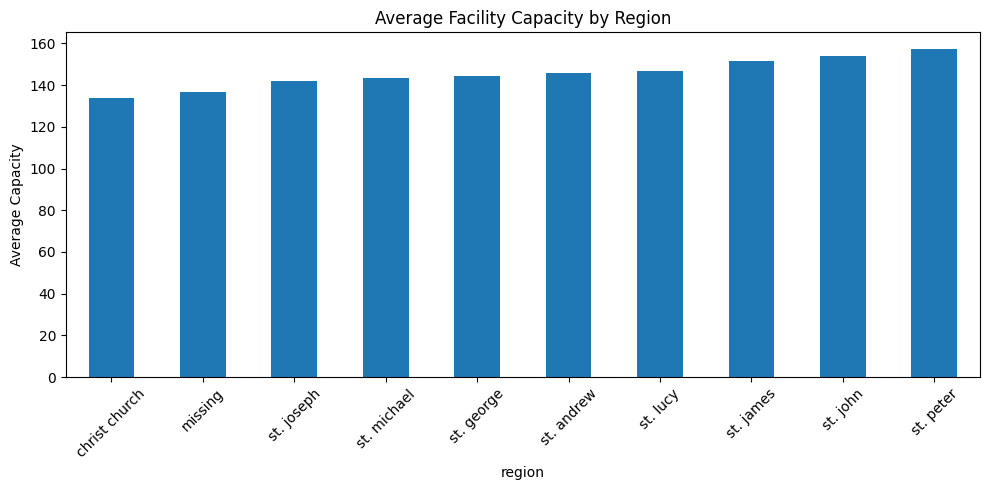

In [160]:
import matplotlib.pyplot as plt

region_capacity = df.groupby("region")["capacity"].mean().sort_values()

region_capacity.plot(kind="bar", figsize=(10,5))
plt.ylabel("Average Capacity")
plt.title("Average Facility Capacity by Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [165]:
region_capacity_std = df.groupby("region")["capacity"].std()
region_capacity_std_floor = np.floor(region_capacity_std)
print(region_capacity_std_floor)

region
christ church    161.0
missing          161.0
st. andrew       165.0
st. george       162.0
st. james        162.0
st. john         163.0
st. joseph       165.0
st. lucy         165.0
st. michael      162.0
st. peter        168.0
Name: capacity, dtype: float64


In [162]:
region_capacity_max = df.groupby("region")["capacity"].max()
region_capacity_min_nonzero = df[df["capacity"] > 0].groupby("region")["capacity"].min()

print("Highest capacity for each region:")
print(region_capacity_max)
print("\nLowest capacity for each region:")
print(region_capacity_min_nonzero)

Highest capacity for each region:
region
christ church    499
missing          497
st. andrew       500
st. george       500
st. james        499
st. john         499
st. joseph       500
st. lucy         500
st. michael      500
st. peter        500
Name: capacity, dtype: int32

Lowest capacity for each region:
region
christ church    1
missing          1
st. andrew       1
st. george       1
st. james        1
st. john         1
st. joseph       1
st. lucy         1
st. michael      1
st. peter        1
Name: capacity, dtype: int32


In [168]:
facility_type_capacity = df.groupby("facility_type")["capacity"].mean()
facility_type_capacity_floor = np.floor(facility_type_capacity)
print(facility_type_capacity_floor)

facility_type
clinic                     146.0
community health center    152.0
health center              136.0
hospital                   147.0
missing                    140.0
polyclinic                 144.0
Name: capacity, dtype: float64


In [172]:
region_capacity_sum = df.groupby("region")["capacity"].sum()
print(region_capacity_sum)

region
christ church    158204
missing          156589
st. andrew       155093
st. george       169340
st. james        169250
st. john         171882
st. joseph       171964
st. lucy         164551
st. michael      158643
st. peter        172033
Name: capacity, dtype: int32
